# Debiasing Facial Detection System
This lab is about removing the biase from the facial detection system. Lets get started.

# 1 Imports

In [1]:
#1 Imports

import os
import random
import IPython
import functools
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.backends import cudnn


#import mit
import mitdeeplearning as mdl

# 2 Datasets
- 3 different datasets are used.
- - Positive: CelebA Dataset: Celebrity Faces
- - Negative: ImageNet : Not faces
- - Fitzpatrick Scale : Skin Type Classification 


In [2]:
# Downloading the dataset
CACHE_DIR = Path.cwd() /".cache" / "mitdeeplearning"
CACHE_DIR.mkdir(parents = True, exist_ok = True)
print (f"Path : {CACHE_DIR}")

#Get the training data from both  datasets
path_to_training_data = CACHE_DIR.joinpath("train_face.h5")
print (f"Path to training data: {path_to_training_data}")


#Create a simple check to avoid re-downloading the dataset
if path_to_training_data.is_file():
    print(f"Using Cache Data : {path_to_training_data}")
else:
    print(f"Downloading dataset to {path_to_training_data} ")
    url = "https://www.dropbox.com/s/hlz8atheyozp1yx/train_face.h5?dl=1"
    torch.hub.download_url_to_file(url, path_to_training_data)



Path : d:\DL_Repos\introtodeeplearning\HayatLabs\.cache\mitdeeplearning
Path to training data: d:\DL_Repos\introtodeeplearning\HayatLabs\.cache\mitdeeplearning\train_face.h5
Using Cache Data : d:\DL_Repos\introtodeeplearning\HayatLabs\.cache\mitdeeplearning\train_face.h5


In [3]:
# Institate a Training DataSetLoader using the downloaded dataset
channels_last = False
loader = mdl.lab2.TrainingDatasetLoader(path_to_training_data,channels_last=channels_last)

number_of_training_examples = loader.get_train_size()
(images, labels) = loader.get_batch(100) # it give us numpay array of images and labels

Opening d:\DL_Repos\introtodeeplearning\HayatLabs\.cache\mitdeeplearning\train_face.h5
Loading data into memory...


In [4]:
B, C, H, W = images.shape
print(f"Batch Size: {B}, Channels: {C}, Height: {H}, Width: {W}")

Batch Size: 100, Channels: 3, Height: 64, Width: 64


In [5]:
import ipywidgets as widgets
from IPython.display import display

# Examining the dataset
def show_images(idx_face=0, idx_not_face=0):
    face_images = images[np.where(labels==1)[0]].transpose(0,2,3,1)
    not_faces_images = images[np.where(labels==0)[0]].transpose(0,2,3,1)

    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(face_images[idx_face])
    plt.title("Face")
    plt.grid(False)

    plt.subplot(1,2,2)
    plt.imshow(not_faces_images[idx_not_face])
    plt.title("Not Face")
    plt.grid(False)
    
    plt.show()

widgets.interact(show_images, idx_face=(0, 49), idx_not_face=(0, 49))

interactive(children=(IntSlider(value=0, description='idx_face', max=49), IntSlider(value=0, description='idx_…

<function __main__.show_images(idx_face=0, idx_not_face=0)>

In [6]:
# To confirm that loader give us numpy array
#(images, labels) = loader.get_batch(100)
print(type(images))
print(type(labels))
print(f"Images shape: {images.shape}" )            

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Images shape: (100, 3, 64, 64)


In [ ]:
# Import h5py library to explore HDF5 file metadata
import h5py
with h5py.File (path_to_training_data, 'r') as f:
    print(f"Exploring h5 dataset")
    print(f"Number of Folders in h5: {len(f.keys())}")
    print(f"Names of folders : {list(f.keys())}")
    for k in f.keys():
        dataset = f[k]
        print(f"Dataset Name: {k}")
        print(f"Shape: {dataset.shape} ")
        print(f"Data Type: {dataset.dtype}")    

Exploring h5 dataset
Number of Folders in h5: 2
Names of folders : ['images', 'labels']
Dataset Name: images
Shape: (109914, 64, 64, 3) 
Data Type: uint8
Dataset Name: labels
Shape: (109914, 1) 
Data Type: uint8


In [ ]:
# Display one image from the dataset directly

with h5py.File(path_to_training_data, 'r') as f:
    for k in f.keys():
        if images == f[k]:
            oneimage = f[k][0]
  

Structure of .h5 file : ['images', 'labels']

Dataset 'images':
  Shape: (109914, 64, 64, 3)
  Data type: uint8
  First image shape: (64, 64, 3)
  First image shape: (64, 64, 3)


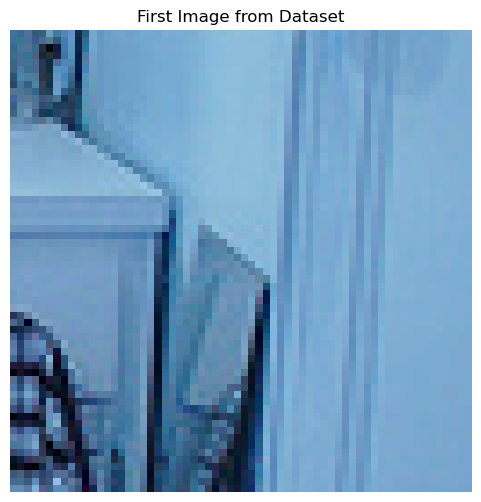

In [17]:
with h5py.File(path_to_training_data,'r') as f:
    print(f"Structure of .h5 file : {list(f.keys())}")
    
# Command 3: Read and display a specific dataset
with h5py.File(path_to_training_data, 'r') as f:
    dataset = f['images']  # Replace 'images' with the actual dataset name
    print(f"\nDataset 'images':")
    print(f"  Shape: {dataset.shape}")
    print(f"  Data type: {dataset.dtype}")
    print(f"  First image shape: {dataset[0].shape}")
    # Handle image display - transpose from CHW to HWC format
    image = dataset[0]
    if len(image.shape) == 3 and image.shape[0] == 3:  # CHW format
        image = image.transpose(1, 2, 0)  # Convert to HWC
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title("First Image from Dataset")
    plt.axis('off')
    plt.show()